In [1]:
import torch
import numpy as np
from copy import deepcopy

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F


from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional
from torch.utils.data import random_split


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Initialization of dataset and augmentation transforms.
Also, the visualization was added.


In [3]:
transform = transforms.Compose(
    [
        # transforms.Pad(padding=4, fill=0),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(size=32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, validset = random_split(dataset, [45000, 5000])
print(len(trainset), len(validset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
45000 5000
Files already downloaded and verified


In [4]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 12))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

['car', 'ship', 'car', 'frog', 'deer', 'frog', 'plane', 'ship', 'cat', 'cat']


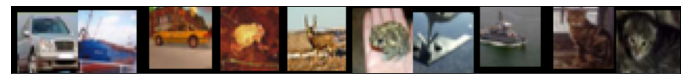

In [5]:
img_list = [trainset[i][0] for i in range(10)]
label_list = [classes[trainset[i][1]] for i in range(10)]
grid = make_grid(img_list, padding=0, nrow=10, normalize=True)
print(label_list)
show(grid)

**Model**

In [6]:
class ResNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=3, padding=1, stride=stride, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features=out_channels)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                         kernel_size=3, padding=1, stride=1, bias=False)
    self.bn2 = nn.BatchNorm2d(num_features=out_channels)
    self.relu = nn.ReLU()

    self.use_padding = (in_channels != out_channels)


  def forward(self, x):
    x1 = self.relu(self.bn1(self.conv1(x)))
    x2 = self.bn2(self.conv2(x1))

    if self.use_padding:
      # dimensions are not matched hence we need to use shortcut
      # tensor: BxCxHxW
      padding_shape = []
              
      for i in range(len(x.shape)-1, -1, -1):
        padding_shape.append((x2.shape[i] - x.shape[i])//2)
        padding_shape.append((x2.shape[i] - x.shape[i])//2)

      x = nn.functional.pad(x, padding_shape, "constant", 0)

    return self.relu(x2 + x)

class ResNetLayer(nn.Module):
  def __init__(self, in_channels, out_channels, first_stride, N=3):
    super().__init__()
    layers = [
        ResNetBlock(in_channels=in_channels, out_channels=out_channels, stride=first_stride)
    ]

    for _ in range(N-1):
      layers.append(
          ResNetBlock(in_channels=out_channels, out_channels=out_channels, stride=1)
      )
    
    self.layer = nn.Sequential(*layers)
      
  
  def forward(self, x):
    return self.layer(x)



In [7]:
class ResNet(nn.Module):
    def __init__(self, N=3, num_classes=10):
        super().__init__()
        self.N = N
        self.num_classes = num_classes

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu = nn.ReLU()

        # 32x32 map size layers
        self.layer32 = ResNetLayer(in_channels=16, out_channels=16, first_stride=1, N=N)

        # 16x16 map size layers
        self.layer16 = ResNetLayer(in_channels=16, out_channels=32, first_stride=2, N=N)

        # 8x8 map size layers
        self.layer8 = ResNetLayer(in_channels=32, out_channels=64, first_stride=2, N=N)

        # avg pool and fc layers
        self.avg_pool = nn.AvgPool2d(kernel_size=8)
        self.fc = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
      x = self.relu(self.bn1(self.conv1(x)))

      x = self.layer32(x)

      x = self.layer16(x)

      x = self.layer8(x)

      x = self.avg_pool(x)
      x = self.fc(x.squeeze())
      
      return x


**Hyperparameters**

Initialization of optimizer, scheduler, number of iterations, and the depth of the model

Depth of the model is described as an integer **n** in the [paper](https://arxiv.org/pdf/1512.03385.pdf). Therefore, in fact, the depth of the model is 6*n+2.

For instance, the value of n for ResNet20 must be 3.

In [8]:
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
DEPTH = 3

In [9]:
model = ResNet(N=3, num_classes=10)

print(f'Model is initialized, the total number of parameters is {sum(p.numel() for p in model.parameters())/1000000 :.3f}M')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=32000, gamma=0.1)

Model is initialized, the total number of parameters is 0.270M


**Training**

In [10]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

dataiter = iter(cycle(trainloader))

In [11]:
MAX_STEPS = 48000
running_loss = 0.0
best_error = 1.0
best_state_dict = model.state_dict()

model.to(device)
for step_number, data in enumerate(dataiter):

  if step_number == MAX_STEPS:
    print("End of training"); break;
  
  x, y = data

  x, y = x.to(device), y.to(device)
  optimizer.zero_grad()

  outputs = model(x)

  loss = criterion(outputs, y)
  loss.backward()

  optimizer.step()
  scheduler.step()

  running_loss += loss.item()
  if step_number % 2000 == 0:    # print every 2000 mini-batches
    print(f'[{step_number:5d}] loss: {running_loss / 2000:.3f}')
    running_loss = 0.0

    # evaluate on validation set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
      for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        correct += torch.sum(predictions==labels).item()
        total += labels.size(0)



    error = 1 - (correct/total)
    if error < best_error:
      best_error = error
      print(f'Error rate has dropped to {best_error:.3f}')
      best_state_dict = deepcopy(model.state_dict())
    
    # turn on train mode back
    model.train()


[    0] loss: 0.001
Error rate has dropped to 0.885
[ 2000] loss: 1.141
Error rate has dropped to 0.306
[ 4000] loss: 0.666
Error rate has dropped to 0.235
[ 6000] loss: 0.521
Error rate has dropped to 0.210
[ 8000] loss: 0.448
Error rate has dropped to 0.171
[10000] loss: 0.402
[12000] loss: 0.368
Error rate has dropped to 0.165
[14000] loss: 0.343
Error rate has dropped to 0.162
[16000] loss: 0.327
[18000] loss: 0.313
[20000] loss: 0.300
Error rate has dropped to 0.155
[22000] loss: 0.290
Error rate has dropped to 0.153
[24000] loss: 0.282
[26000] loss: 0.280
[28000] loss: 0.269
Error rate has dropped to 0.139
[30000] loss: 0.263
[32000] loss: 0.260
Error rate has dropped to 0.136
[34000] loss: 0.131
Error rate has dropped to 0.092
[36000] loss: 0.097
Error rate has dropped to 0.086
[38000] loss: 0.083
[40000] loss: 0.073
[42000] loss: 0.066
[44000] loss: 0.061
[46000] loss: 0.055
End of training


**Testing our best model on test set**

In [12]:
model.load_state_dict(best_state_dict)

model.eval()
correct, total = 0, 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    correct += torch.sum(predictions==labels).item()
    total += labels.size(0)

test_error = 1 - (correct/total)
print(f'Error on the test set is {test_error:.5f}')


Error on the test set is 0.09280
